Penny is organizing a party at her apartment, but she is on a tight budget. Having a working knowledge of all of the important things in the universe, Sheldon knows everything about linear programming and offered to help her. He postulates that it’s ideal to have two kinds of mixed nuts: a plain party mix, and a luxury mix (for those with a distinct taste like himself). Based on the expected number of guests, Howard quickly calculates that they’ll need a total of at least 10 pounds of snacks, but no more than 6 pounds of each kind of mix. On his white board, Sheldon has already come up with the following table:

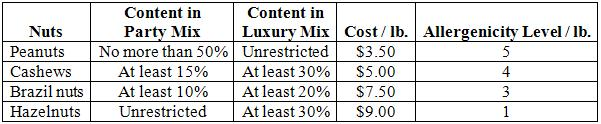

Raj wants to dip the hazelnuts into liquor, but that’s not in the budget, so he gives up. Leonard reminds everyone that, because of their allergies, it’s important to keep the average allergenicity level per pound in both mixes to no more than 3. Write an optimization model to help Penny prepare the two kinds of snacks at minimum cost. But be careful: Sheldon will check it later for correctness!

Constants
- c_p = 3.5
- c_c = 5
- c_b = 7.5
- c_h = 9
- allerg_p = 5
- allerg_c = 4
- allerg_b = 3
- allerg_h = 1

Variables
- amount in party of Peanuts (ap_p)
- amount in party of Cashews (ap_c)
- amount in party of Brazil nuts (ap_b)
- amount in party of Hazlenuts (ap_h)
- amount in luxury of peanuts (al_p)
- amount in luxury of cashews (al_c)
- amount in luxury of brazil nuts (al_b)
- amount in luxury of hazlenuts (al_h)

Objective function:
minimize the sum of the costs: 
- min [(ap_p+al_p) * c_p + (ap_c+al_c) * c_c + (ap_b+al_b) * c_b + (ap_h+al_h) * c_h]

Constraints
- ap_p + ap_c + ap_b + ap_h + al_p + al_c + al_b + al_h ≤ 10

party_mix_constraints
- ap_p + ap_c + ap_b + ap_h ≤ 6
- allerg_p * ap_p + allerg_c * ap_c + allerg_b * ap_b + allerg_h * ap_h / (ap_p + ap_c + ap_b + ap_h) ≤ 3
- ap_p / (ap_p+ap_c+ap_b+ap_h) ≤ 0.5
- ap_c / (ap_p+ap_c+ap_b+ap_h) ≥ 0.15
- ap_b / (ap_p+ap_c+ap_b+ap_h) ≥ 0.1

luxury mix constraints
- al_p + al_c + al_b + al_h ≤ 6
- allerg_p * al_p + allerg_c * al_c + allerg_b * al_b + allerg_h * al_h / (al_p + al_c + al_b + al_h) ≤ 3
- al_c / (al_p+al_c+al_b+al_h) ≥ 0.3
- al_b / (al_p+al_c+al_b+al_h) ≥ 0.2
- al_h / (al_p+al_c+al_b+al_h) ≥ 0.3


In [137]:
from pyomo.environ import *
from pyomo.opt import SolverFactory
opt = SolverFactory("gurobi")

model = AbstractModel()

model.nuts = Param(within=NonNegativeIntegers) # Types of nuts (4 in our case)
model.mixes = Param(within=NonNegativeIntegers) # Types of mixes (2 in our case)
model.N = RangeSet(1,model.nuts)
model.M = RangeSet(1,model.mixes)

# Model Parameters
model.cost = Param(model.N,within=NonNegativeReals) # Costs associated with each pound of each type of nuts
model.allergies = Param(model.N,within=NonNegativeIntegers) # Allergy level associated with each type of nuts

# Mixes parameters
model.total_max_amount = Param(within=NonNegativeIntegers) # Total amount of nuts (10 pounds in our case)
model.upper_bounds = Param(model.N,model.M,within=NonNegativeReals) # M = 1 -> Party; M = 2 -> Luxury in our case
model.lower_bounds = Param(model.N,model.M,within=NonNegativeReals)
model.mixes_max_amount = Param(model.M, within=NonNegativeIntegers)
model.max_allergy = Param(model.M,within=NonNegativeIntegers)

# Variables of the model
model.x = Var(model.N, model.M)

# Objective Rule
def obj_rule(model):
    return sum(sum(model.x[n,m] for m in model.M)*model.cost[n] for n in model.N)
model.Obj = Objective(rule=obj_rule, sense=minimize)

## Total Amount
def total_amount(model):
    return sum(sum(model.x[n,m] for n in model.N) for m in model.M) == model.total_max_amount
model.total_amount_constraint = Constraint(rule=total_amount)

## Mixes constraints
# Total mix amount constraint
def mix_amount(model, m):
    return sum(model.x[n,m] for n in model.N) <= model.mixes_max_amount[m]
model.mix_amount_constraint = Constraint(model.M, rule = mix_amount)

# Mix upper proportions constraint
def upper_proportion(model, n, m):
    return model.x[n,m] <= model.upper_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N)
model.upper_prop_constraint = Constraint(model.N, model.M, rule = upper_proportion)

# Mix lower proportions constraints
def lower_proportion(model, n, m):
    return model.x[n,m] >= model.lower_bounds[n,m]*sum(model.x[n0,m] for n0 in model.N)
model.lower_prop_constraint = Constraint(model.N, model.M, rule = lower_proportion)

# Allergies constraints
def allergies_constr(model, m):
    return sum(model.x[n,m]*model.allergies[n] for n in model.N) <= model.max_allergy[m]*sum(model.x[n0,m] for n0 in model.N)
model.allergies_constraint = Constraint(model.M, rule = allergies_constr)

In [140]:
%%writefile nuts_mixes.dat

param nuts := 4
;

param mixes := 2
;

param cost :=
1 3.5
2 5
3 7.5
4 9
;

param allergies :=
1 5
2 4
3 3
4 1
;

param total_max_amount := 10
;

param upper_bounds :	1	2:=
1	0.5	1
2	1	1
3	1	1
4	1	1
;

param lower_bounds :	1	2:=
1	0	0
2	0.15	0.3
3	0.1	0.2
4	0	0.3
;

param mixes_max_amount := 
1 6
2 6
;

param max_allergy :=
1 3
2 3
;

Overwriting nuts_mixes.dat


In [141]:
instance = model.create_instance('nuts_mixes.dat')
#instance.pprint()
results = opt.solve(instance, tee=True)
print(results)
for i in range(4):
    for j in range(2):
        print(instance.x[i+1,j+1].value)

Academic license - for non-commercial use only
Read LP format model from file /Users/Jaime/Desktop/Master/Optimisation/Optimization-Project/tmpxuje8ele.pyomo.lp
Reading time = 0.00 seconds
x9: 22 rows, 9 columns, 71 nonzeros
Optimize a model with 22 rows, 9 columns and 71 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [4e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 4 rows and 1 columns
Presolve time: 0.00s
Presolved: 18 rows, 8 columns, 67 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
      14    6.4512500e+01   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.00 seconds
Optimal objective  6.451250000e+01

Problem: 
- Name: x9
  Lower bound: 64.5125
  Upper bound: 64.5125
  Number of objectives: 1
  Number of constraints: 22
  Number of variables: 9
  Number of binary variables: 0
  Numbe